# Learning to Simulate an LIF Model
## November 3, 2025

The aspect of this project with which I am least familiar is in the numerical simulation of differential equations. Although I am familiar with the theory I have never learned much about numerical methods for solving ODE's. My first goal is to rigorously define what it is I am simulating mathematically, then explore the my resources for the appropriate numerical method.

### Dynamics

The basic component of the LIF model describing the change in membrane voltage is given by

$$
\tau \frac{d}{dt}V(t) = -(V(t) - V_\text{rest}) + R \space I(t)
$$

where we have


- $\tau = RC : \text{time constant of the circuit}$
- $V : \text{Membrane potential}$
- $V_\text{rest} : \text{Resting potential}$
- $R : \text{Resistance}$
- $I(t) : \text{Current}$


The second component of this model is the "fire" component, which generates a spike when the voltage reaches a chosen threshhold, and resets the voltage back to $V_\text{reset}$. Mathematically, for firing time $t^{f}$ and threshold $\vartheta$, a spike, or firing, occurs when

$$
V(t^{f}) = \vartheta.
$$

It follows that the spike train for a neuron $i$ can be expressed with the Dirac delta function:

$$
S_i(t) = \sum_f \delta (t - t_i^f)
$$

There are appropriate alternative representations for spikes that have different characteristics than those of the Dirac delta function.

### Numerical Methods

Some numerical methods we could look into using are [**Euler's method**](https://en.wikipedia.org/wiki/Euler_method) for simplicity or [**RK4**](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) for accuracy.

For example, using Euler's method, we choose our total time interval $[0, T_\text{total}]$, say $1$ second ($1000$ ms). Then we partition $[0, T_\text{total}]$ into equal discrete intervals of length $\Delta t$, say $\Delta t = 0.1$ ms. Then $V(t + \Delta t) = V(t) + \Delta t \cdot \frac{d}{dt} V(t)$.

### Parameters

For the parameters of the model, we will use biologically realistic values:

- $\tau = 10 \text{ ms}$
- $V_\text{rest} = -70 \text{ mV}$
- $R = 10\space \Omega$
- $\vartheta = -55 \text{mV}$
- $V_\text{reset} = -75 \text{mV}$

### First Attempt

Euler's method with constant $I$:

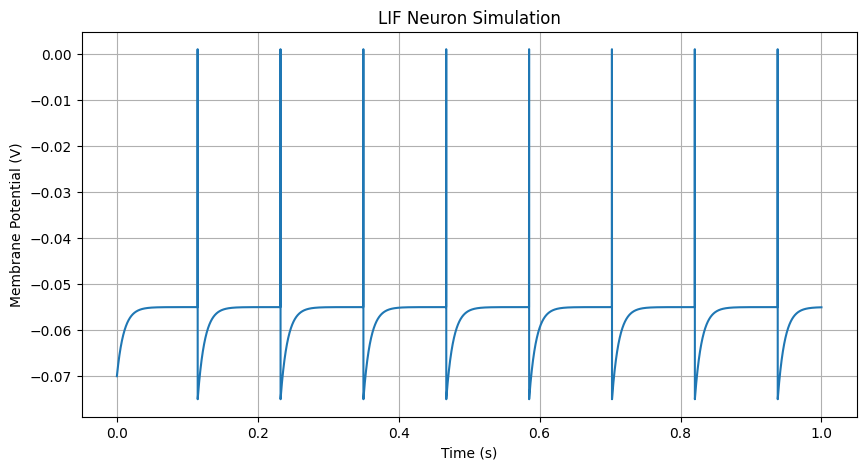

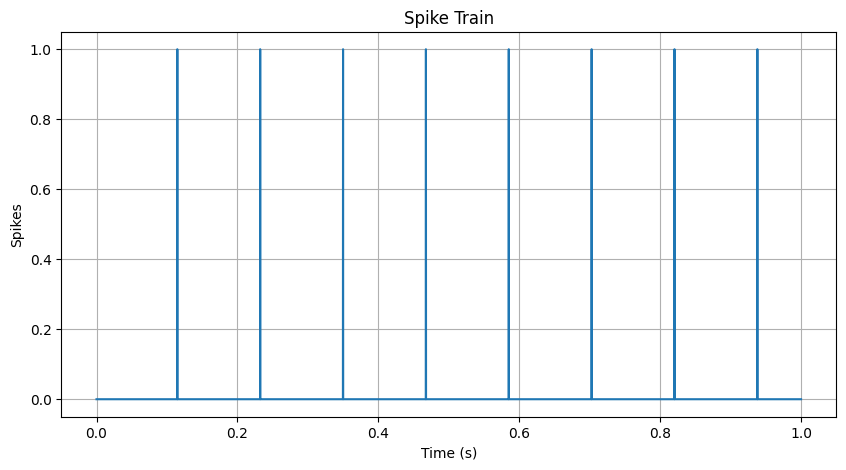

In [1]:
import numpy as np
from matplotlib import pyplot as plt

TAU = 0.010
V_REST = -0.07
R = 10
THRESHOLD = -0.055
V_RESET = -0.075
V_SPIKE = 0.001

T_TOTAL = 1 
DELTA = 0.0001
time_steps = int(T_TOTAL / DELTA)

#initialize time and potential vectors
t = np.linspace(0, T_TOTAL, time_steps)
V = np.zeros(time_steps)
V[0] = V_REST

#we want to count the spikes and their time stamps for building S_i
spike_counts = 0
spike_times = np.zeros(time_steps)

#use constant value here
RI_input = 1.00001 * (THRESHOLD - V_REST)

for i in range(time_steps - 1):
    
    dV = (-(V[i] - V_REST) + RI_input) / TAU

    # 2. Euler step
    V[i+1] = V[i] + DELTA * dV

    # 3. Check for spike
    if V[i+1] >= THRESHOLD:
        V[i+1] = V_SPIKE

        spike_counts += 1
        spike_times[i+1] = 1

    if V[i] == V_SPIKE:
        V[i+1] = V_RESET


plt.figure(figsize=(10, 5))
plt.plot(t, V)
plt.title("LIF Neuron Simulation")
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (V)")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(t, spike_times)
plt.title("Spike Train")
plt.xlabel("Time (s)")
plt.ylabel('Spikes')
plt.grid(True)
plt.show()

Some notes:

- if RI is too low then no spike can occur

### Fire Rate:

If $N$ is the number of spikes in a given time interval, we have

$$
\text{Firing Rate } (Hz) = \frac{N}{t_\text{total}}
$$

Note that in general, $N = \int_0^{t_\text{total}} S_i(t) \space dt = \sum_f 1$.

In [2]:
fire_rate = spike_counts / T_TOTAL

print(f'Fire rate: {fire_rate} spikes per second.')

Fire rate: 16.0 spikes per second.


### What does a Poission current look like?

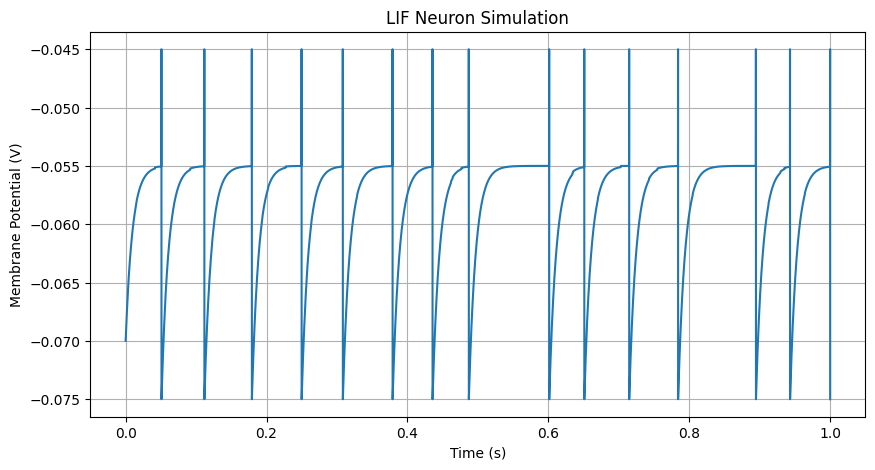

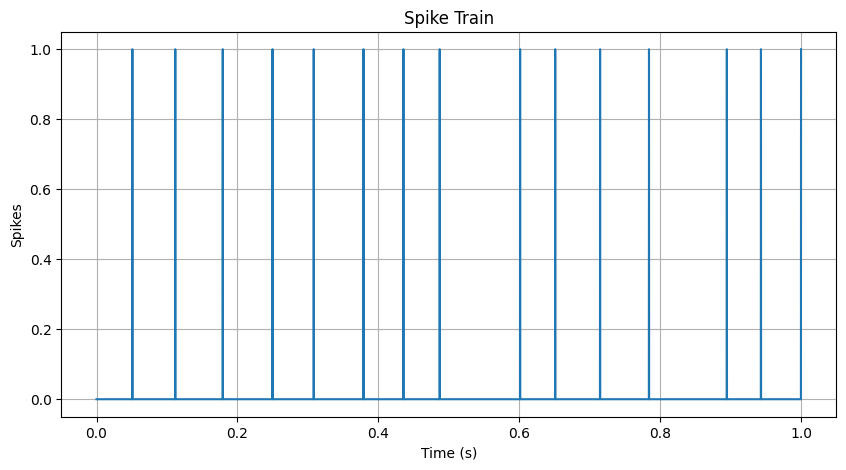

In [22]:
import numpy as np
from matplotlib import pyplot as plt

TAU = 0.010
V_REST = -0.07
R = 10
THRESHOLD = -0.055
V_RESET = -0.075
V_SPIKE = THRESHOLD + 0.01

T_TOTAL = 1 
DELTA = 0.0001
time_steps = int(T_TOTAL / DELTA)

# initialize time and potential vectors
t = np.linspace(0, T_TOTAL, time_steps)
V = np.zeros(time_steps)
V[0] = V_REST

# we want to count the spikes and their time stamps for building S_i
spike_counts = 0
spike_times = np.zeros(time_steps)

# use constant value plus poisson spike
rate_HZ = 50 # rate of background noise - x incoming spikes in voltage per second
weight = 0.01 # size of spike - 10 mV per spike

poisson_additive = np.random.default_rng().poisson(lam=rate_HZ*DELTA, size=time_steps)* weight
RI_input = 1.0000001 * (THRESHOLD - V_REST) + poisson_additive

for i in range(time_steps - 1):
    
    dV = (-(V[i] - V_REST) + RI_input[i]) / TAU

    # 2. Euler step
    V[i+1] = V[i] + DELTA * dV

    # 3. Check for spike
    if V[i+1] >= THRESHOLD:

        # artificial peak for visualization
        V[i+1] = V_SPIKE

        spike_counts += 1
        spike_times[i+1] = 1

    if V[i] == V_SPIKE:
        V[i+1] = V_RESET


plt.figure(figsize=(10, 5))
plt.plot(t, V)
plt.title("LIF Neuron Simulation")
plt.xlabel("Time (s)")
plt.ylabel("Membrane Potential (V)")
plt.grid(True)
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(t, spike_times)
plt.title("Spike Train")
plt.xlabel("Time (s)")
plt.ylabel('Spikes')
plt.grid(True)
plt.show()

### Spike Train Kernel Density Estimation

We want to estimate the probability of a spike occuring in a small time interval $\Delta t$, so we do this by producing a kernel density estimation (KDE) of the spike train by convolving the spike train with a Gaussian distribtuion. The result is a smoothed version of the spike train.

Rather than assuming deterministic spike times we assume that the probability of a spike is normally distributed around its observed time.

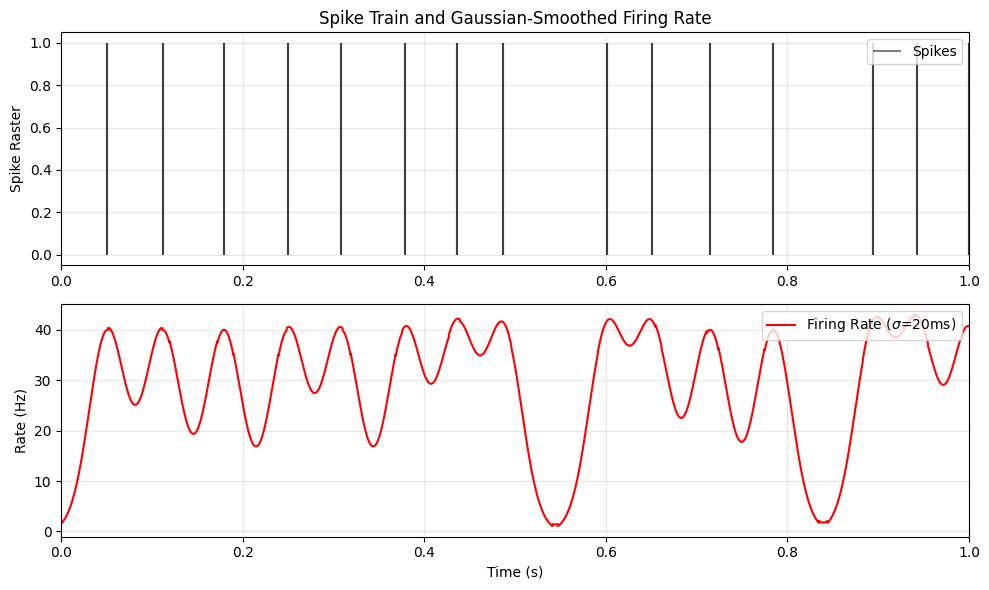

In [ ]:
# 1. Define Gaussian Kernel
sigma_sec = 0.02  # 20 ms standard deviation for smoothing
sigma_bins = int(sigma_sec / DELTA)
k_width = sigma_bins * 6 + 1  # +/- 3 sigma covers >99% of the curve
k_time = np.arange(-k_width//2, k_width//2 + 1) * DELTA
kernel = np.exp(-k_time**2 / (2 * sigma_sec**2))
kernel = kernel / np.sum(kernel)  # Normalize kernel area to 1

# 2. Convolve
# mode='same' keeps the output the same length as 't'
firing_rate_hz = np.convolve(spike_times, kernel, mode='same') / DELTA

# 3. Plot
plt.figure(figsize=(10, 6))

# Plot Spikes (top panel)
plt.subplot(2, 1, 1)
# Use vlines for cleaner spike raster visualization
plt.vlines(t[spike_times == 1], ymin=0, ymax=1, color='k', alpha=0.5, label='Spikes')
plt.ylabel("Spike Raster")
plt.title("Spike Train and Gaussian-Smoothed Firing Rate")
plt.xlim(0, T_TOTAL)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

# Plot Firing Rate
plt.subplot(2, 1, 2)
plt.plot(t, firing_rate_hz, color='r', label=f'Firing Rate ($\\sigma$={sigma_sec*1000:.0f}ms)')
plt.xlabel("Time (s)")
plt.ylabel("Rate (Hz)")
plt.xlim(0, T_TOTAL)
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()